## 구글 드라이브 마운트

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# cd /content/drive/MyDrive/데이터 마법사들

In [3]:
# pwd

In [4]:
!pip install timm

In [5]:
!pip install einops

## Import

In [6]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to c:\users\user\appdata\local\temp\pip-req-build-l_pa5pw8
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e5d3db20e9c2ddb76f88642409e527239943c983
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch 'C:\Users\user\AppData\Local\Temp\pip-req-build-l_pa5pw8'


In [7]:
import os
import cv2
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from einops import rearrange, repeat
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import timm
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter
import segmentation_models_pytorch as smp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\user\anaconda3\envs\DeMa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
print(device)

cuda


## Seed 설정

In [9]:
def seed_everything(seed: int = 42, contain_cuda: bool = False):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f"Seed set as {seed}")

In [10]:
seed_everything(seed=2023)

Seed set as 2023


## Utils

In [11]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [12]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Data Loader

In [13]:
transform = A.Compose(
    [
        A.Resize(224, 224),
        # A.HorizontalFlip(p=0.5),
        # A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.15, p=0.5),
        # A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
        # A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=25, val_shift_limit=10, p=0.5),
        A.Normalize(),
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='./train.csv', transform=transform)
dataset_size = len(dataset)
train_size = int(dataset_size * 0.9)
val_size = int(dataset_size * 0.1)
train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True)

## Define Model

## Deeplab V3+

### Encoder

In [14]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
# from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d

def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class SeparableConv2d(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, dilation=1, bias=False, BatchNorm=None):
        super(SeparableConv2d, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, inplanes, kernel_size, stride, 0, dilation,
                               groups=inplanes, bias=bias)
        self.bn = BatchNorm(inplanes)
        self.pointwise = nn.Conv2d(inplanes, planes, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = fixed_padding(x, self.conv1.kernel_size[0], dilation=self.conv1.dilation[0])
        x = self.conv1(x)
        x = self.bn(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self, inplanes, planes, reps, stride=1, dilation=1, BatchNorm=None,
                 start_with_relu=True, grow_first=True, is_last=False):
        super(Block, self).__init__()

        if planes != inplanes or stride != 1:
            self.skip = nn.Conv2d(inplanes, planes, 1, stride=stride, bias=False)
            self.skipbn = BatchNorm(planes)
        else:
            self.skip = None

        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = inplanes
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(inplanes, planes, 3, 1, dilation, BatchNorm=BatchNorm))
            rep.append(BatchNorm(planes))
            filters = planes

        for i in range(reps - 1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters, filters, 3, 1, dilation, BatchNorm=BatchNorm))
            rep.append(BatchNorm(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(inplanes, planes, 3, 1, dilation, BatchNorm=BatchNorm))
            rep.append(BatchNorm(planes))

        if stride != 1:
            rep.append(self.relu)
            rep.append(SeparableConv2d(planes, planes, 3, 2, BatchNorm=BatchNorm))
            rep.append(BatchNorm(planes))

        if stride == 1 and is_last:
            rep.append(self.relu)
            rep.append(SeparableConv2d(planes, planes, 3, 1, BatchNorm=BatchNorm))
            rep.append(BatchNorm(planes))

        if not start_with_relu:
            rep = rep[1:]

        self.rep = nn.Sequential(*rep)

    def forward(self, inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x = x + skip

        return x


class AlignedXception(nn.Module):
    """
    Modified Alighed Xception
    """
    def __init__(self, output_stride, BatchNorm,
                 pretrained=True):
        super(AlignedXception, self).__init__()

        if output_stride == 16:
            entry_block3_stride = 2
            middle_block_dilation = 1
            exit_block_dilations = (1, 2)
        elif output_stride == 8:
            entry_block3_stride = 1
            middle_block_dilation = 2
            exit_block_dilations = (2, 4)
        else:
            raise NotImplementedError


        # Entry flow
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False)
        self.bn1 = BatchNorm(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1, bias=False)
        self.bn2 = BatchNorm(64)

        self.block1 = Block(64, 128, reps=2, stride=2, BatchNorm=BatchNorm, start_with_relu=False)
        self.block2 = Block(128, 256, reps=2, stride=2, BatchNorm=BatchNorm, start_with_relu=False,
                            grow_first=True)
        self.block3 = Block(256, 728, reps=2, stride=entry_block3_stride, BatchNorm=BatchNorm,
                            start_with_relu=True, grow_first=True, is_last=True)

        # Middle flow
        self.block4  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block5  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block6  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block7  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block8  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block9  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block10 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block11 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block12 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block13 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block14 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block15 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block16 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block17 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block18 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block19 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)

        # Exit flow
        self.block20 = Block(728, 1024, reps=2, stride=1, dilation=exit_block_dilations[0],
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=False, is_last=True)

        self.conv3 = SeparableConv2d(1024, 1536, 3, stride=1, dilation=exit_block_dilations[1], BatchNorm=BatchNorm)
        self.bn3 = BatchNorm(1536)

        self.conv4 = SeparableConv2d(1536, 1536, 3, stride=1, dilation=exit_block_dilations[1], BatchNorm=BatchNorm)
        self.bn4 = BatchNorm(1536)

        self.conv5 = SeparableConv2d(1536, 2048, 3, stride=1, dilation=exit_block_dilations[1], BatchNorm=BatchNorm)
        self.bn5 = BatchNorm(2048)

        # Init weights
        self._init_weight()

        # Load pretrained model
        if pretrained:
            self._load_pretrained_model()

    def forward(self, x):
        # Entry flow
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.block1(x)
        # add relu here
        x = self.relu(x)
        low_level_feat = x
        x = self.block2(x)
        x = self.block3(x)

        # Middle flow
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        x = self.block13(x)
        x = self.block14(x)
        x = self.block15(x)
        x = self.block16(x)
        x = self.block17(x)
        x = self.block18(x)
        x = self.block19(x)

        # Exit flow
        x = self.block20(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)

        return x, low_level_feat

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            # elif isinstance(m, SynchronizedBatchNorm2d):
            #     m.weight.data.fill_(1)
            #     m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def _load_pretrained_model(self):
        pretrain_dict = model_zoo.load_url('http://data.lip6.fr/cadene/pretrainedmodels/xception-b5690688.pth')
        model_dict = {}
        state_dict = self.state_dict()

        for k, v in pretrain_dict.items():
            if k in state_dict:
                if 'pointwise' in k:
                    v = v.unsqueeze(-1).unsqueeze(-1)
                if k.startswith('block11'):
                    model_dict[k] = v
                    model_dict[k.replace('block11', 'block12')] = v
                    model_dict[k.replace('block11', 'block13')] = v
                    model_dict[k.replace('block11', 'block14')] = v
                    model_dict[k.replace('block11', 'block15')] = v
                    model_dict[k.replace('block11', 'block16')] = v
                    model_dict[k.replace('block11', 'block17')] = v
                    model_dict[k.replace('block11', 'block18')] = v
                    model_dict[k.replace('block11', 'block19')] = v
                elif k.startswith('block12'):
                    model_dict[k.replace('block12', 'block20')] = v
                elif k.startswith('bn3'):
                    model_dict[k] = v
                    model_dict[k.replace('bn3', 'bn4')] = v
                elif k.startswith('conv4'):
                    model_dict[k.replace('conv4', 'conv5')] = v
                elif k.startswith('bn4'):
                    model_dict[k.replace('bn4', 'bn5')] = v
                else:
                    model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)

def build_backbone(backbone, output_stride, BatchNorm):
    return AlignedXception(output_stride, BatchNorm)

### ASPP

In [15]:
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, BatchNorm):
        super(_ASPPModule, self).__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                            stride=1, padding=padding, dilation=dilation, bias=False)
        self.bn = BatchNorm(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            # elif isinstance(m, SynchronizedBatchNorm2d):
            #     m.weight.data.fill_(1)
            #     m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, backbone, output_stride, BatchNorm):
        super(ASPP, self).__init__()
        if backbone == 'drn':
            inplanes = 512
        elif backbone == 'mobilenet':
            inplanes = 320
        else:
            inplanes = 2048
        if output_stride == 16:
            dilations = [1, 6, 12, 18]
        elif output_stride == 8:
            dilations = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        self.aspp1 = _ASPPModule(inplanes, 256, 1, padding=0, dilation=dilations[0], BatchNorm=BatchNorm)
        self.aspp2 = _ASPPModule(inplanes, 256, 3, padding=dilations[1], dilation=dilations[1], BatchNorm=BatchNorm)
        self.aspp3 = _ASPPModule(inplanes, 256, 3, padding=dilations[2], dilation=dilations[2], BatchNorm=BatchNorm)
        self.aspp4 = _ASPPModule(inplanes, 256, 3, padding=dilations[3], dilation=dilations[3], BatchNorm=BatchNorm)

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(inplanes, 256, 1, stride=1, bias=False),
                                             BatchNorm(256),
                                             nn.ReLU())
        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = BatchNorm(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self._init_weight()

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return self.dropout(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            # elif isinstance(m, SynchronizedBatchNorm2d):
            #     m.weight.data.fill_(1)
            #     m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


def build_aspp(backbone, output_stride, BatchNorm):
    return ASPP(backbone, output_stride, BatchNorm)

### Decoder

In [16]:
class Decoder(nn.Module):
    def __init__(self, num_classes, backbone, BatchNorm):
        super(Decoder, self).__init__()
        low_level_inplanes = 128
        # if backbone == 'resnet' or backbone == 'drn':
        #     low_level_inplanes = 256
        # elif backbone == 'xception':

        # elif backbone == 'mobilenet':
        #     low_level_inplanes = 24
        # else:
        #     raise NotImplementedError

        self.conv1 = nn.Conv2d(low_level_inplanes, 48, 1, bias=False)
        self.bn1 = BatchNorm(48)
        self.relu = nn.ReLU()
        self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.1),
                                       nn.Conv2d(256, num_classes, kernel_size=1, stride=1))
        self._init_weight()


    def forward(self, x, low_level_feat):
        low_level_feat = self.conv1(low_level_feat)
        low_level_feat = self.bn1(low_level_feat)
        low_level_feat = self.relu(low_level_feat)

        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x, low_level_feat), dim=1)
        x = self.last_conv(x)

        return x

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            # elif isinstance(m, SynchronizedBatchNorm2d):
            #     m.weight.data.fill_(1)
            #     m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

def build_decoder(num_classes, backbone, BatchNorm):
    return Decoder(num_classes, backbone, BatchNorm)

### Deeplab

In [17]:
class DeepLab(nn.Module):
    def __init__(self, backbone='resnet', output_stride=16, num_classes=1,
                 sync_bn=True, freeze_bn=False):
        super(DeepLab, self).__init__()
        # if backbone == 'drn':
        #     output_stride = 8

        # if sync_bn == True:
        #     BatchNorm = SynchronizedBatchNorm2d
        # else:
        BatchNorm = nn.BatchNorm2d

        self.backbone = build_backbone(backbone, output_stride, BatchNorm)
        self.aspp = build_aspp(backbone, output_stride, BatchNorm)
        self.decoder = build_decoder(num_classes, backbone, BatchNorm)

        self.freeze_bn = freeze_bn

    def forward(self, input):
        x, low_level_feat = self.backbone(input)
        x = self.aspp(x)
        x = self.decoder(x, low_level_feat)
        x = F.interpolate(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x

In [18]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [19]:
model = DeepLab().to(device)

## Model Train

In [20]:
import numpy as np
import pandas as pd
from typing import List, Union
from joblib import Parallel, delayed

def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''


    # Keep only the rows in the prediction dataframe that have matching img_ids in the ground truth dataframe
    prediction_df = prediction_df[prediction_df.iloc[:, 0].isin(ground_truth_df.iloc[:, 0])]
    prediction_df.index = range(prediction_df.shape[0])


    # Extract the mask_rle columns
    pred_mask_rle = prediction_df.iloc[:, 1]
    gt_mask_rle = ground_truth_df.iloc[:, 1]


    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)


        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None


    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )


    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values


    return np.mean(dice_scores)

In [21]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [22]:
# model 초기화
# model = UNet().to(device)
# model = UNetFormer().to(device)

# loss function과 optimizer 정의
# criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.0001)
Dice_Loss = smp.losses.DiceLoss(mode='binary')
train_running_loss_history = []
val_running_loss_history = []

# training loop
for epoch in range(150):  # 10 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    val_epoch_loss = 0
    for images, masks in tqdm(train_dataloader, desc = 'train'):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        # outputs = outputs.reshape(-1, 1, 224, 224)

        loss = Dice_Loss(outputs, masks.unsqueeze(1))
        # dice_score = calculate_dice_scores(outputs, masks.unsqueeze(1))
        # loss = 1 - dice_score

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_running_loss_history.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_dataloader)}')

    with torch.no_grad():
        model.eval()
        for val_images, val_masks in tqdm(val_dataloader, desc = 'validation'):
            val_images = val_images.float().to(device)
            val_masks = val_masks.float().to(device)

            val_outputs = model(val_images)
            # val_outputs = val_outputs.reshape(-1, 1, 224, 224)

            validation_loss = Dice_Loss(val_outputs, val_masks.unsqueeze(1))

            # val_dice_score = calculate_dice_scores(val_outputs, val_masks.unsqueeze(1))
            # val_loss = 1- val_dice_score

            val_epoch_loss += loss.item()

    val_running_loss_history.append(val_epoch_loss)
    print(f'Epoch {epoch+1}, VAL_Loss: {val_epoch_loss/len(val_dataloader)}')

    scheduler.step()

train: 100%|██████████| 402/402 [04:37<00:00,  1.45it/s]


Epoch 1, Loss: 0.5398223234053275


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 1, VAL_Loss: 0.3523672819137573


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 2, Loss: 0.4082492370510576


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 2, VAL_Loss: 0.4372091293334961


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 3, Loss: 0.3686617018275


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 3, VAL_Loss: 0.3499720096588135


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 4, Loss: 0.35119572622859063


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 4, VAL_Loss: 0.3176344037055969


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 5, Loss: 0.3362646483959843


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 5, VAL_Loss: 0.32421815395355225


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 6, Loss: 0.32690805122626954


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 6, VAL_Loss: 0.339884877204895


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 7, Loss: 0.3187695562246427


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 7, VAL_Loss: 0.2838181257247925


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 8, Loss: 0.31336888937807794


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 8, VAL_Loss: 0.32901984453201294


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 9, Loss: 0.3057889260759401


validation: 100%|██████████| 45/45 [00:20<00:00,  2.19it/s]


Epoch 9, VAL_Loss: 0.3759709596633911


train: 100%|██████████| 402/402 [04:41<00:00,  1.43it/s]


Epoch 10, Loss: 0.2997134010590131


validation: 100%|██████████| 45/45 [00:22<00:00,  1.97it/s]


Epoch 10, VAL_Loss: 0.28420156240463257


train: 100%|██████████| 402/402 [05:11<00:00,  1.29it/s]


Epoch 11, Loss: 0.2955123884464378


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 11, VAL_Loss: 0.30003541707992554


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 12, Loss: 0.2896968786099657


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 12, VAL_Loss: 0.2559358477592468


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 13, Loss: 0.2875963602196518


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 13, VAL_Loss: 0.26530134677886963


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 14, Loss: 0.28527203394998957


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 14, VAL_Loss: 0.26954156160354614


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 15, Loss: 0.283549581001054


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 15, VAL_Loss: 0.28016865253448486


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 16, Loss: 0.28163207288998277


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 16, VAL_Loss: 0.32264626026153564


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 17, Loss: 0.2775897708401751


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 17, VAL_Loss: 0.30065256357192993


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 18, Loss: 0.27366326845700467


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 18, VAL_Loss: 0.27277421951293945


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 19, Loss: 0.27122505772766187


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 19, VAL_Loss: 0.2521781325340271


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 20, Loss: 0.2705335228597347


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 20, VAL_Loss: 0.2749652862548828


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 21, Loss: 0.2674628605890037


validation: 100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


Epoch 21, VAL_Loss: 0.2505658268928528


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 22, Loss: 0.2658465730017097


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 22, VAL_Loss: 0.34006941318511963


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 23, Loss: 0.2646285666162102


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 23, VAL_Loss: 0.2674708962440491


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 24, Loss: 0.2667578860598417


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 24, VAL_Loss: 0.27799010276794434


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 25, Loss: 0.2649214909740941


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 25, VAL_Loss: 0.2619088888168335


train: 100%|██████████| 402/402 [04:37<00:00,  1.45it/s]


Epoch 26, Loss: 0.2581618927901064


validation: 100%|██████████| 45/45 [00:19<00:00,  2.31it/s]


Epoch 26, VAL_Loss: 0.2337910532951355


train: 100%|██████████| 402/402 [04:56<00:00,  1.36it/s]


Epoch 27, Loss: 0.25760642642998577


validation: 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


Epoch 27, VAL_Loss: 0.2075682282447815


train: 100%|██████████| 402/402 [04:37<00:00,  1.45it/s]


Epoch 28, Loss: 0.2547608823028963


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 28, VAL_Loss: 0.287841260433197


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 29, Loss: 0.25510746240615845


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 29, VAL_Loss: 0.28965961933135986


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 30, Loss: 0.253867402895173


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 30, VAL_Loss: 0.26369595527648926


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 31, Loss: 0.25043715202986305


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 31, VAL_Loss: 0.2584722638130188


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 32, Loss: 0.2493879760972303


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 32, VAL_Loss: 0.1992674469947815


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 33, Loss: 0.24775531635948675


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 33, VAL_Loss: 0.2025355100631714


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 34, Loss: 0.24529674352698067


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 34, VAL_Loss: 0.2438604235649109


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 35, Loss: 0.2484533533231536


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 35, VAL_Loss: 0.2528965473175049


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 36, Loss: 0.24270606693343735


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 36, VAL_Loss: 0.2739470601081848


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 37, Loss: 0.24120790507662948


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 37, VAL_Loss: 0.2655453085899353


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 38, Loss: 0.2410682537662449


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 38, VAL_Loss: 0.21941816806793213


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 39, Loss: 0.23830847271639316


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 39, VAL_Loss: 0.23315763473510742


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 40, Loss: 0.2362259215679928


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 40, VAL_Loss: 0.22596025466918945


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 41, Loss: 0.23662142537126493


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 41, VAL_Loss: 0.21262365579605103


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 42, Loss: 0.2379830758369977


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 42, VAL_Loss: 0.2501083016395569


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 43, Loss: 0.23533699465035207


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 43, VAL_Loss: 0.25222164392471313


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 44, Loss: 0.23217606114510872


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 44, VAL_Loss: 0.26103395223617554


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 45, Loss: 0.2304858955281291


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 45, VAL_Loss: 0.21385180950164795


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 46, Loss: 0.23295954492554735


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 46, VAL_Loss: 0.23726016283035278


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 47, Loss: 0.22965494539607223


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 47, VAL_Loss: 0.18830204010009766


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 48, Loss: 0.22802715381579614


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 48, VAL_Loss: 0.2137414813041687


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 49, Loss: 0.22574697931607565


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 49, VAL_Loss: 0.22931557893753052


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 50, Loss: 0.22478830502994024


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 50, VAL_Loss: 0.2574186325073242


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 51, Loss: 0.22632513043299243


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 51, VAL_Loss: 0.21639889478683472


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 52, Loss: 0.22380628336721392


validation: 100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


Epoch 52, VAL_Loss: 0.20314544439315796


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 53, Loss: 0.22317704676988706


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 53, VAL_Loss: 0.19934016466140747


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 54, Loss: 0.22167802405594594


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 54, VAL_Loss: 0.23398065567016602


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 55, Loss: 0.22067613091634875


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 55, VAL_Loss: 0.23825132846832275


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 56, Loss: 0.21946850166985052


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 56, VAL_Loss: 0.1947723627090454


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 57, Loss: 0.21898340570985975


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 57, VAL_Loss: 0.21855652332305908


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 58, Loss: 0.21797571283074754


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 58, VAL_Loss: 0.2006203532218933


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 59, Loss: 0.21695629103266778


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 59, VAL_Loss: 0.18589293956756592


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 60, Loss: 0.2160783202493962


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 60, VAL_Loss: 0.2020757794380188


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 61, Loss: 0.2147973867791209


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 61, VAL_Loss: 0.2464504837989807


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 62, Loss: 0.21492954035896567


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 62, VAL_Loss: 0.16073864698410034


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 63, Loss: 0.21323876609256612


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 63, VAL_Loss: 0.19821351766586304


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 64, Loss: 0.2125149750294377


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 64, VAL_Loss: 0.206415057182312


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 65, Loss: 0.2113061396043692


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 65, VAL_Loss: 0.24013537168502808


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 66, Loss: 0.21001685199452869


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 66, VAL_Loss: 0.225422203540802


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 67, Loss: 0.2100743823383578


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 67, VAL_Loss: 0.2239585518836975


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 68, Loss: 0.20974241160041657


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 68, VAL_Loss: 0.21366488933563232


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 69, Loss: 0.20806923582779235


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 69, VAL_Loss: 0.20792222023010254


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 70, Loss: 0.20764139754262137


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 70, VAL_Loss: 0.20334315299987793


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 71, Loss: 0.20727210332505144


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 71, VAL_Loss: 0.25498420000076294


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 72, Loss: 0.20664273447065212


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 72, VAL_Loss: 0.20379406213760376


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 73, Loss: 0.20565440805990304


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 73, VAL_Loss: 0.21297574043273926


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 74, Loss: 0.2049172713388851


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 74, VAL_Loss: 0.2526487112045288


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 75, Loss: 0.20423705838806


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 75, VAL_Loss: 0.20171105861663818


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 76, Loss: 0.2037837950151358


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 76, VAL_Loss: 0.14045113325119019


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 77, Loss: 0.20266214769278


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 77, VAL_Loss: 0.263075590133667


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 78, Loss: 0.20233660180177263


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 78, VAL_Loss: 0.20169347524642944


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 79, Loss: 0.201859210261065


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 79, VAL_Loss: 0.19586342573165894


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 80, Loss: 0.20153185324882394


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 80, VAL_Loss: 0.23956161737442017


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 81, Loss: 0.20013967838453417


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 81, VAL_Loss: 0.19205009937286377


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 82, Loss: 0.20037102476874394


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 82, VAL_Loss: 0.1491086483001709


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 83, Loss: 0.2001739903468991


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 83, VAL_Loss: 0.23545372486114502


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 84, Loss: 0.19934052065830327


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 84, VAL_Loss: 0.18450182676315308


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 85, Loss: 0.19870200382536324


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 85, VAL_Loss: 0.23301339149475098


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 86, Loss: 0.19872912082506056


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 86, VAL_Loss: 0.1897881031036377


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 87, Loss: 0.19791804009409092


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 87, VAL_Loss: 0.19501638412475586


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 88, Loss: 0.19802104922669445


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 88, VAL_Loss: 0.17392778396606445


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 89, Loss: 0.1976452920567337


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 89, VAL_Loss: 0.19186854362487793


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 90, Loss: 0.19763697557781465


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 90, VAL_Loss: 0.18287527561187744


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 91, Loss: 0.19679045425125616


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 91, VAL_Loss: 0.19073015451431274


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 92, Loss: 0.19642333827208525


validation: 100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


Epoch 92, VAL_Loss: 0.14243441820144653


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 93, Loss: 0.19662106259545284


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 93, VAL_Loss: 0.19074738025665283


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 94, Loss: 0.1959332187673939


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 94, VAL_Loss: 0.16966509819030762


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 95, Loss: 0.19623489018103377


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 95, VAL_Loss: 0.19049936532974243


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 96, Loss: 0.19619850688312776


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 96, VAL_Loss: 0.20409125089645386


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 97, Loss: 0.1956392827615216


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 97, VAL_Loss: 0.23256248235702515


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 98, Loss: 0.19607597915687372


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 98, VAL_Loss: 0.2041565179824829


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 99, Loss: 0.1957545348660863


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 99, VAL_Loss: 0.19604533910751343


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 100, Loss: 0.1956379505532298


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 100, VAL_Loss: 0.19304442405700684


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 101, Loss: 0.1953842973531182


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 101, VAL_Loss: 0.19221919775009155


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 102, Loss: 0.19533127931813102


validation: 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


Epoch 102, VAL_Loss: 0.24139726161956787


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 103, Loss: 0.19539884414838915


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 103, VAL_Loss: 0.2114059329032898


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 104, Loss: 0.19558087198888485


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 104, VAL_Loss: 0.2099187970161438


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 105, Loss: 0.19496332635333882


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 105, VAL_Loss: 0.21290093660354614


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 106, Loss: 0.19496959566476926


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 106, VAL_Loss: 0.20511460304260254


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 107, Loss: 0.1953947971116251


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 107, VAL_Loss: 0.14338034391403198


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 108, Loss: 0.19518615891091265


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 108, VAL_Loss: 0.2206982970237732


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 109, Loss: 0.19515875485999074


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 109, VAL_Loss: 0.16741293668746948


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 110, Loss: 0.19504454984000666


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 110, VAL_Loss: 0.19439399242401123


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 111, Loss: 0.19456504974792252


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 111, VAL_Loss: 0.1253761649131775


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 112, Loss: 0.19541309010330124


validation: 100%|██████████| 45/45 [00:18<00:00,  2.49it/s]


Epoch 112, VAL_Loss: 0.21207982301712036


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 113, Loss: 0.19484060083455707


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 113, VAL_Loss: 0.21932584047317505


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 114, Loss: 0.195635677421864


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 114, VAL_Loss: 0.18526023626327515


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 115, Loss: 0.19465008704223444


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 115, VAL_Loss: 0.17814159393310547


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 116, Loss: 0.19502508877521724


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 116, VAL_Loss: 0.18308627605438232


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 117, Loss: 0.1947250047429877


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 117, VAL_Loss: 0.15963566303253174


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 118, Loss: 0.1946443833818483


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 118, VAL_Loss: 0.22272080183029175


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 119, Loss: 0.1948445891562979


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 119, VAL_Loss: 0.17793548107147217


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 120, Loss: 0.19500751652527804


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 120, VAL_Loss: 0.2037590742111206


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 121, Loss: 0.1948312237784637


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 121, VAL_Loss: 0.1490333080291748


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 122, Loss: 0.19427338791130788


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 122, VAL_Loss: 0.23261839151382446


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 123, Loss: 0.19464790954518674


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 123, VAL_Loss: 0.21156030893325806


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 124, Loss: 0.19555289872843234


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 124, VAL_Loss: 0.18662035465240479


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 125, Loss: 0.19496623927087925


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 125, VAL_Loss: 0.20349061489105225


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 126, Loss: 0.19585755393279725


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 126, VAL_Loss: 0.22892773151397705


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 127, Loss: 0.1952180496199214


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 127, VAL_Loss: 0.14757245779037476


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 128, Loss: 0.1953517096256142


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 128, VAL_Loss: 0.2001255750656128


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 129, Loss: 0.19640737846123046


validation: 100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


Epoch 129, VAL_Loss: 0.18538659811019897


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 130, Loss: 0.19531843184831724


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 130, VAL_Loss: 0.18940865993499756


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 131, Loss: 0.1958113785703384


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 131, VAL_Loss: 0.1757705807685852


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 132, Loss: 0.19619865619128024


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 132, VAL_Loss: 0.1618778109550476


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 133, Loss: 0.1956737032577173


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 133, VAL_Loss: 0.22540068626403809


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 134, Loss: 0.19660509225740955


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 134, VAL_Loss: 0.21207958459854126


train: 100%|██████████| 402/402 [04:34<00:00,  1.47it/s]


Epoch 135, Loss: 0.19697064902651962


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 135, VAL_Loss: 0.25064945220947266


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 136, Loss: 0.1965411212017287


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 136, VAL_Loss: 0.133309006690979


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 137, Loss: 0.19738472397647686


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 137, VAL_Loss: 0.23147684335708618


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 138, Loss: 0.19792616634226556


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 138, VAL_Loss: 0.18465864658355713


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 139, Loss: 0.19905748251658767


validation: 100%|██████████| 45/45 [00:18<00:00,  2.49it/s]


Epoch 139, VAL_Loss: 0.19833248853683472


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 140, Loss: 0.19886316321975556


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 140, VAL_Loss: 0.17574584484100342


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 141, Loss: 0.19781334216321877


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 141, VAL_Loss: 0.2712175250053406


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 142, Loss: 0.19914151691085663


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 142, VAL_Loss: 0.18574607372283936


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 143, Loss: 0.19967605507195885


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 143, VAL_Loss: 0.192379891872406


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 144, Loss: 0.20031323080039143


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 144, VAL_Loss: 0.20110821723937988


train: 100%|██████████| 402/402 [04:35<00:00,  1.46it/s]


Epoch 145, Loss: 0.20165296647679154


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 145, VAL_Loss: 0.20037829875946045


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 146, Loss: 0.20018571437294805


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 146, VAL_Loss: 0.24018198251724243


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 147, Loss: 0.20108785335697346


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 147, VAL_Loss: 0.21068698167800903


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 148, Loss: 0.202170719406498


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


Epoch 148, VAL_Loss: 0.23781275749206543


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 149, Loss: 0.20098925570943463


validation: 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


Epoch 149, VAL_Loss: 0.22070258855819702


train: 100%|██████████| 402/402 [04:34<00:00,  1.46it/s]


Epoch 150, Loss: 0.20182013689582026


validation: 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]

Epoch 150, VAL_Loss: 0.1957266926765442


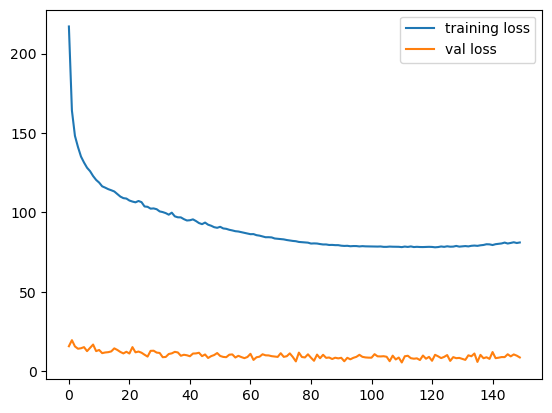

In [23]:
plt.plot(train_running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='val loss')
plt.legend()

## Inference

In [24]:
test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [25]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

100%|██████████| 3790/3790 [13:56<00:00,  4.53it/s]


## Submission

In [26]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

In [27]:
submit.to_csv('./submit.csv', index=False)